# Build a Stocks Price Prediction App powered by  Snowflake, AWS, Python and Streamlit - Part 3 of 3

A comprehensive guide to develop machine learning applications from start to finish.

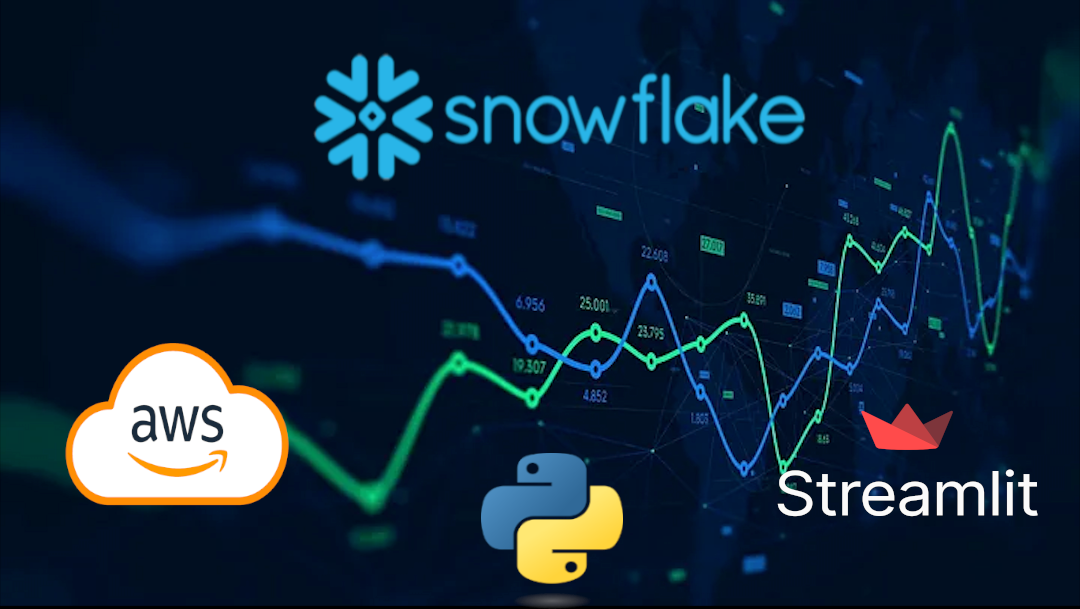


## Introduction

Thanks for joining me again, This the final chapter of our Machine Learning journey. If you here first time then please checkout these two articles in sequence TODO. Most of the Heavy lifting is done in previous article, but this phase is also equally Important. In this article we will see how the machine learning product is delivered to the end user. 

We will learns some interesting new techniques...

## Project Layout

Here are the high-level steps for this project , In this last article we will cover **Machine Learning Model deployment** & **Web App development** 

1. **Data collection**: Automatically download the stock historical prices data in csv format and save it AWS S3 bucket.


2. **Data storage**: Store the data in a Snowflake data warehouse by creating data pipe between AWS and Snowflake.


3. **Data Extraction, Preprocessing & EDA**: Extract & Pre-process the data using Python and perform basic Exploratory Data Analysis.


4. **Machine Learning Model development**: Develop a machine learning model, Train the model on historical data, Evaluate the model and perform hyper parameter tunning 


5. **<u>Machine Learning Model deployment</u>**: Deploy the final model on Snowflake.


6. **<u>Web App development</u>**: Build a web app using Streamlit and Python to interact with the deployed model and display the predictions. And Deploy the final app on Streamlit Cloud.

## 5. Machine Learning Model deployment

Model deployment involves taking a trained machine learning model and making it available for use in a production environment. Typically This can be done by packaging the model into a deployable format, such as a container image, and deploying it to a server or cloud platform. Once deployed, the model can be accessed via an API or other interface for real-time predictions or batch processing of data.


But there are several challenges Limited scalability, Difficulties in Maintenance of models & Security risks in Traditional Deployments methods.

To address these issues I am going to show you very interesting and easy  way of deploying machine learning model in production environment. 

We will train and save the model in the SnowFlake stored procedure, and then that stored procedure can be executed via an App, Api or even in SnowFlake itself.

We will perform the following steps 

* Connect snowflake from Python 
* Create SnowFlake stage to save the Stored Procedure 
* Create a Python function to train model
* Register Python function as Snowflake stored procedure
* Execute the Stored Procedure to predict future prices

### Connect snowflake from Python

This is exactly the same step that we have already performed in previous article 

**Import required packages**

In [1]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.types as T
import toml
import pandas as pd
from prophet import Prophet
import json

**Load the credentials from toml file & Connect to Snowflake** 

In [2]:
secrets = toml.load("secrets.toml")

accountname = secrets["SNOWFLAKE"]["account"]
user = secrets["SNOWFLAKE"]["user"]
password = secrets["SNOWFLAKE"]["password"]
role = secrets["SNOWFLAKE"]["role"]
database = secrets["SNOWFLAKE"]["database"]
schema = secrets["SNOWFLAKE"]["schema"]
warehouse = secrets["SNOWFLAKE"]["warehouse"]

connection_parameters = {
    "account": accountname,
    "user": user,
    "password": password,
    "role": role,
    "database": database,
    "schema": schema,
    "warehouse": warehouse,
    "ocsp_fail_open":"False"
}

session = Session.builder.configs(connection_parameters).create()

**Test Connection**

Using **session** object you can run queries on snowflake or retrieve table data, Let's check if connection is working properly   

In [3]:
print(session.sql('select current_warehouse(), current_database(), current_schema()').collect())

[Row(CURRENT_WAREHOUSE()='PRICE_PRED', CURRENT_DATABASE()='PRICE_PRED_DB', CURRENT_SCHEMA()='PRICE_PRED_SCHEMA')]


warehouse, database & schema name is displayed in output, which means connection is successful 

### Prepare Snowflake Stage to store Models

Snowflake stages provide a flexible and scalable way to manage data files that need to be loaded into or unloaded from Snowflake, enabling users to efficiently manage and process large amounts of data.

In this project we will create Snowflake stage to save the stored procedure. 

**Creating Stage**

In [4]:
session.sql('CREATE OR REPLACE STAGE ML_MODELS').collect()

[Row(status='Stage area ML_MODELS successfully created.')]

**Displaying available Stages**

In [5]:
pd.DataFrame(session.sql('SHOW STAGES').collect())

,created_on,name,database_name,schema_name,url,has_credentials,has_encryption_key,owner,comment,region,type,cloud,notification_channel,storage_integration
0,2023-03-12 16:33:38.712000-07:00,ML_MODELS,PRICE_PRED_DB,PRICE_PRED_SCHEMA,,N,N,ACCOUNTADMIN,,None,INTERNAL,None,None,None
1,2023-03-06 01:05:20.298000-08:00,PRICE_PRED_AWS_STAGE,PRICE_PRED_DB,PRICE_PRED_SCHEMA,s3://stocksprice-prediction/,N,N,ACCOUNTADMIN,,us-east-1,EXTERNAL,AWS,None,AWS_S3_INTEGRATION


Above query should show at least 2 stages **PRICE_PRED_AWS_STAGE** this was created in first article to integrate Snowflake with AWS & **ML_MODELS** this was created now.

### Create a Python function to train the model

The beauty of this method is we are using native python code to write snowflake stored procedure.

Lets create a Python function which will extract snowflake data and create a model and predict the future prices. Input parameters are name of the table , include historical prices Y/N & Number of future days to predict prices.

In [6]:
def sproc_predict_using_prophet(session: Session, 
                                training_table: str,
                                include_history: str,
                                period: int) -> T.Variant:
    
    # Loading data into pandas dataframe
    data_sdf = session.table(training_table)    
    data = data_sdf.select('DATE','CLOSE').to_pandas()
    data.drop_duplicates(subset='DATE', keep="last",inplace=True)
    data.sort_values(by='DATE',inplace=True)
    data.columns = ['ds','y']
    
    # Actual model training
    from prophet import Prophet
     
    model = Prophet(changepoint_prior_scale=0.5,
                    seasonality_prior_scale=0.01,
                    seasonality_mode='additive',
                    changepoint_range=0.99
                       )
    model.fit(data)
    
    if include_history == 'Y':
        flag = True
    else:
        flag = False
        
    future_df = model.make_future_dataframe(periods=period,
                                           include_history=flag)
    forecast = model.predict(future_df)
  
    return forecast.to_dict()

All the code is self explanatory, we are not doing anything special here. Model building , Training & data prediction everything was covered in previous article. Here we are just packaging the same code in Python function.

### Register Python function as Snowflake stored procedure

This is the final sage of model deployment, 

First we add the required python packages to session object.

After that use following code template to register the function via session object. you need to provide python function name, name of the stored procedure, stage location etc.

In [7]:
#Adding paclaeges to session.
session.add_packages('snowflake-snowpark-python','prophet')
# Registering the function as a Stored Procedure
sproc_predict_using_prophet = session.sproc.register(func=sproc_predict_using_prophet, 
                                            name='sproc_predict_using_prophet', 
                                            is_permanent=True, 
                                            replace=True, 
                                            stage_location='@ML_MODELS', 
                                            packages=['prophet==1.0.1', 'holidays==0.18','snowflake-snowpark-python'])


Its is not complex as it looks. In simple words we are just creating a Snowflake stored procedure using python code.

If everything went well, you should see the stored procedure in Snowflake console 

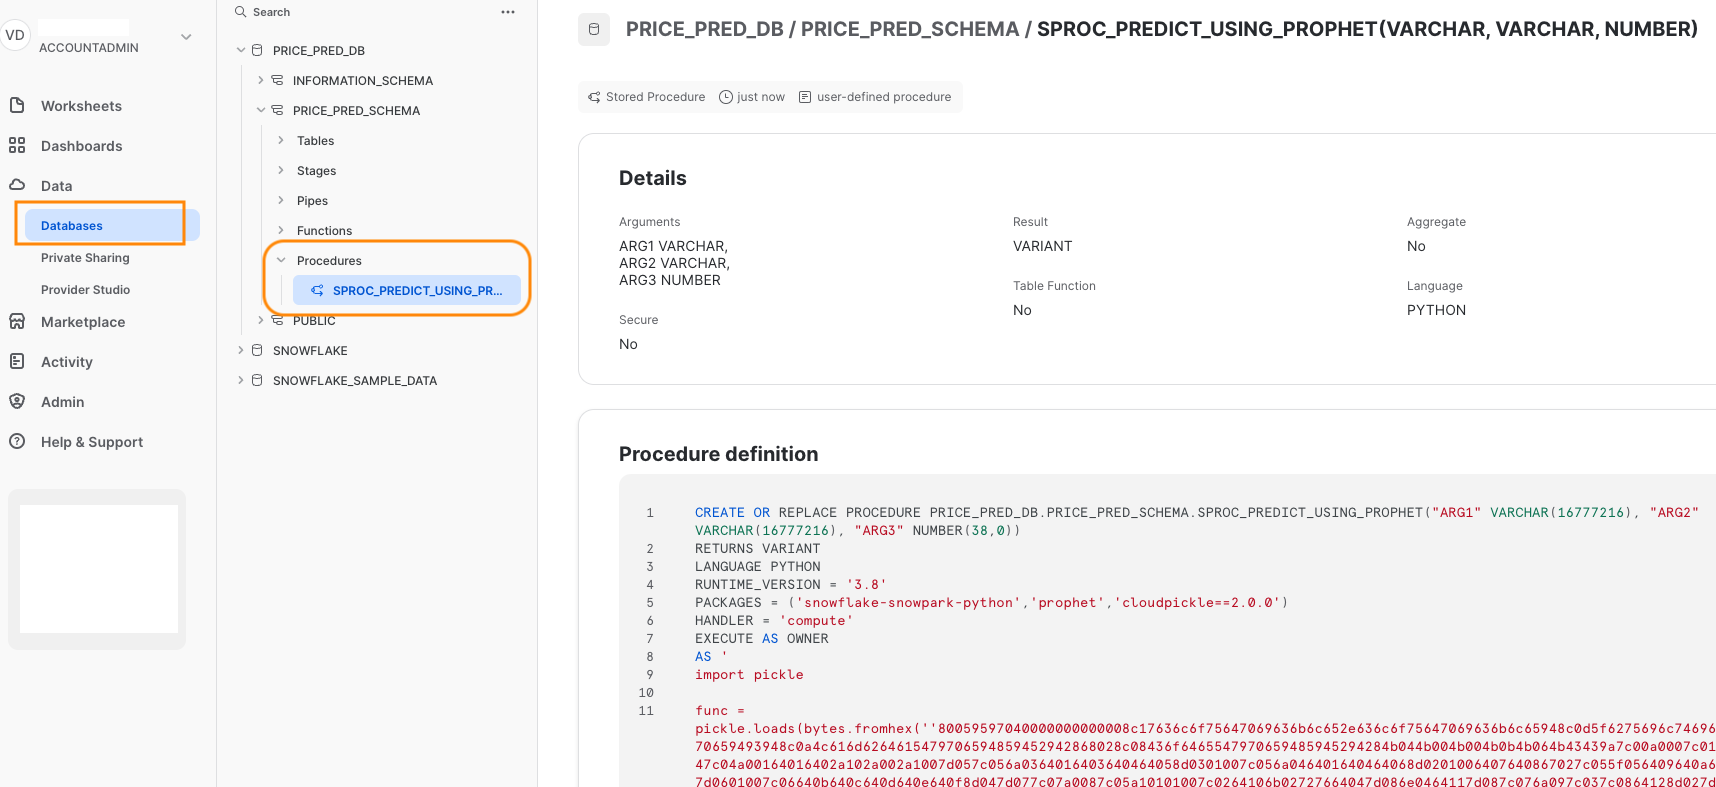

### Execute the Stored Procedure to predict future prices

We can execute the stored procedure (which predicts the future stock prices) in SnowFlake as well as in Python code or any custom App.

Following code demonstrate how run the stored procedure in python, we can call the stored procedure execution sql statement in **session.sql()**, I have passed the table name , show history flag & number of days to predict.

The output of the stored procedure is grabbed in Pandas Dataframe.

In [8]:
training_table = 'historical_prices'
show_history='N'
future_days=4

pred_list = session.sql(
            "call sproc_predict_using_prophet('{}', '{}',{})".format(training_table,show_history, future_days)   
            ).collect()

pred_df = pd.DataFrame(json.loads(pred_list[0][0]))
pred_df = pred_df[['ds','yhat']]
pred_df['ds'] = pd.to_datetime(pred_df['ds']).dt.date
pred_df.columns = ['DATE', 'PRICE']
pred_df

,DATE,PRICE
0,2023-03-11,97.367571
1,2023-03-12,97.509316
2,2023-03-13,97.562289
3,2023-03-14,97.708742


Deploying Machine Learning models in Snowflake was like a cake walk, we don't need to worry about packaging, scaling and security. The price predictions via executing stored procedure is also very easy and convenient.  

This concludes the Model Deployment section, Lets move Ahead to final section of this project.

## 6. Web App development

This is the final stage of our project, and its success ultimately depends on whether the machine learning models are able to effectively address real-life problems faced by end users. Therefore, this phase is crucially important.

During this stage, we will be developing an interactive web application that will allow users to view the future prices of Google and some interesting visualizations.

There are tons of ways to web app, but in this project we create the app using Streamlit & Deploy it on Streamlit cloud.

We will perform following steps 

* Getting started with Streamlit
* Build the web App
* Deploy the web App 

### What is Streamlit

Streamlit is an open-source Python library that allows developers to easily create interactive web applications for machine learning and data science projects. With Streamlit, developers can quickly create custom user interfaces with interactive widgets and visualizations, and can update the UI in real-time based on user inputs.

### Getting started with Streamlit

This will be a quick tutorial on Streamlit, to facilitate the web app creation.


* **Create HelloStreamlit.py file in the project directory**<br>
    Type following code in the HelloStreamlit.py and save the file.<br> 
    `import streamlit as st`<br><br>
    `st.title('Hello Streamlit')`<br><br>    


* **Open Terminal**<br>
    * Open Anaconda / Miniconda Terminal (as shown in earlier article)
    Type following commands<br>
    `conda deactivate`<br>
    `conda activate stocksenv`<br>

    * Navigate to Project directory using cd command<br><br>
    
    
* **Run Streamlit**<br> 
    Type following command on Terminal<br>
    `streamlit run  HelloStreamlit.py`<br>
    
    If prompted to enter email id type your email id, running this command will open a new web page having title "Hello Streamlit".<br> 
    
    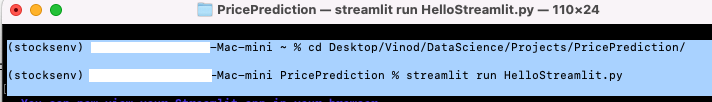<br>
    
    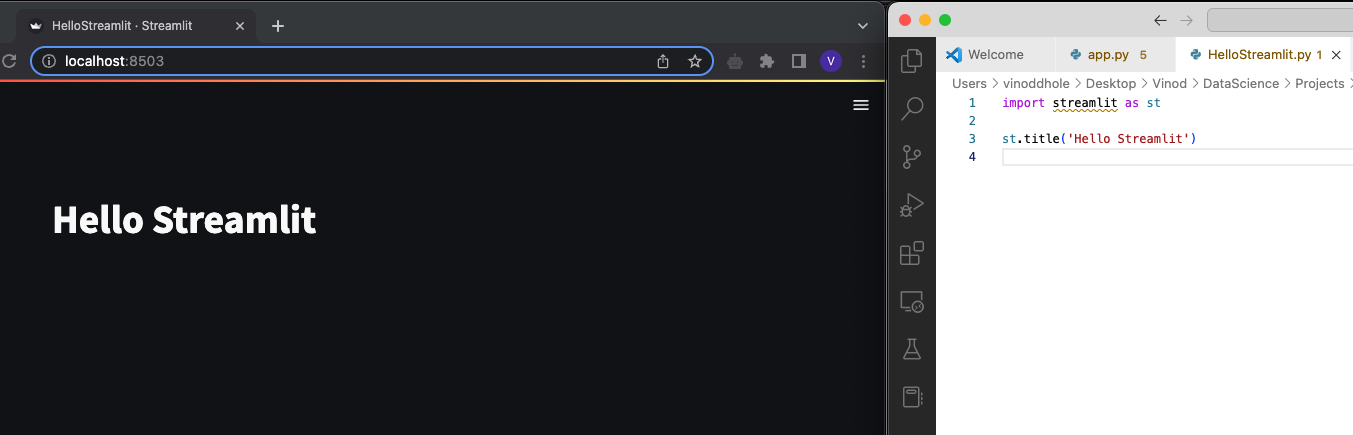<br>
    
    
* **subheader**<br>
    Add following code in the HelloStreamlit.py and save the file.<br> 
    `st.subheader('This is Sub Header')`<br>
   
    After that switch back to Streamlit web app,you can either refresh the wen page or click Re run button on top right. Subheader "This is Sub Header" will display on the app.<br>
    

* **selectbox**<br>
    Add following code in the HelloStreamlit.py and save the file.<br>  
    `selected_stock = st.selectbox('Select Option', ('One', 'Two', 'Three'))`<br> 
    `st.text(selected_stock)`<br>
    
    The web page should display Selection Drop down. Upon selecting any one option, the selected option should display in text.<br>
    
    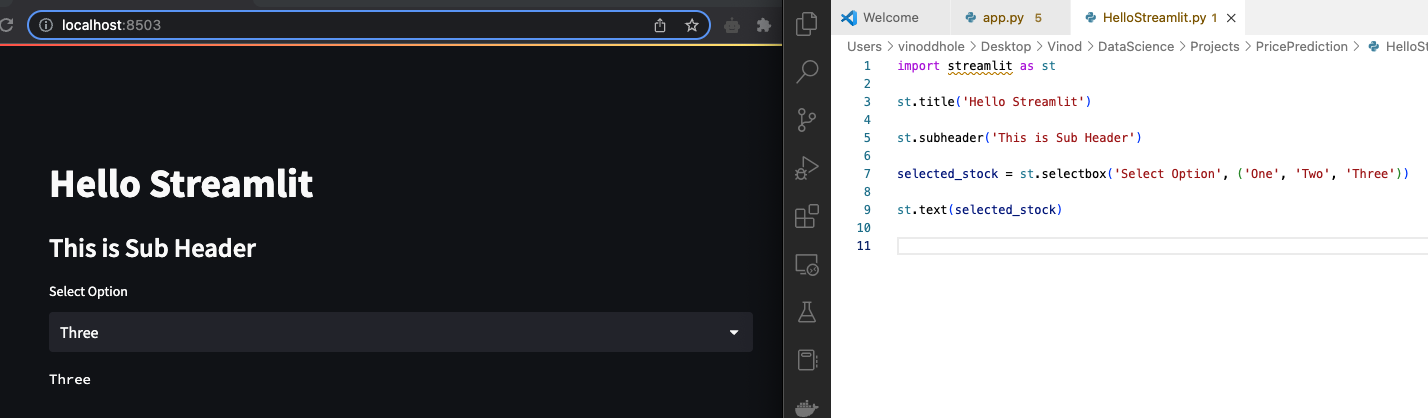<br>

* **slider**<br>
    Add following code in the HelloStreamlit.py and save the file.<br>  
    `slider = st.slider('Select Slider', 1, 100,11)`<br>
    
    Web page should display slider , you can slide down to any value for on slider bar.<br>
    
    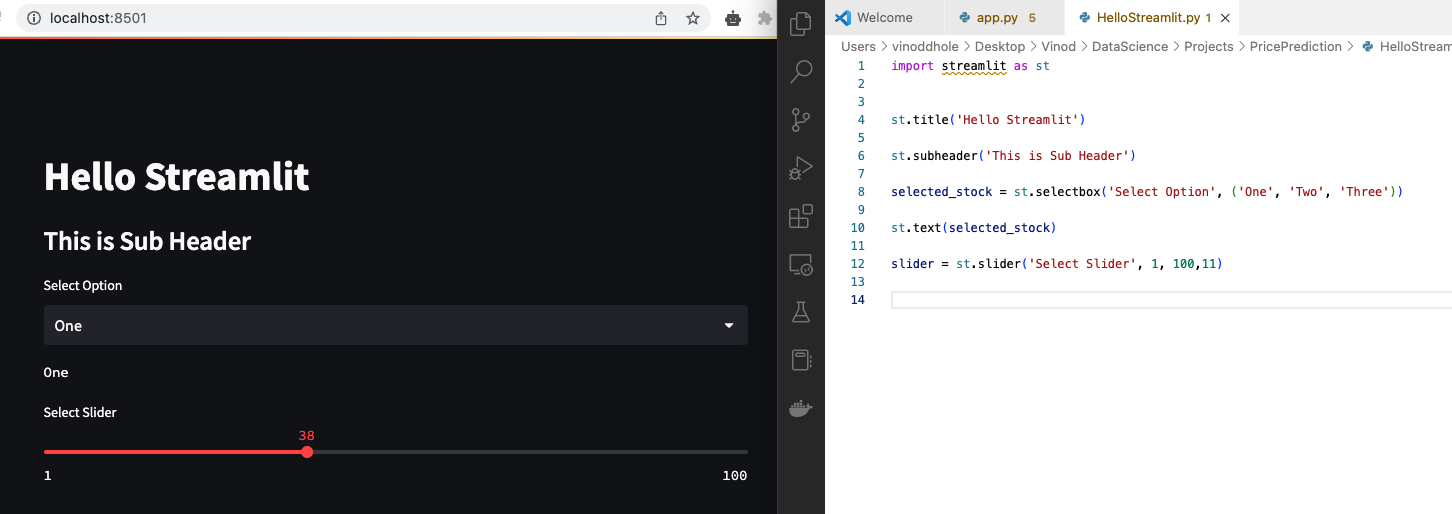<br>

* **button**<br>
    Add following code in the HelloStreamlit.py and save the file.<br>  
    `if st.button('Click Here'):`<br>
    `st.text(slider)`<br>
    
    Web page should display a button, Click button you  should see the values selected on slider bar.<br>
    
    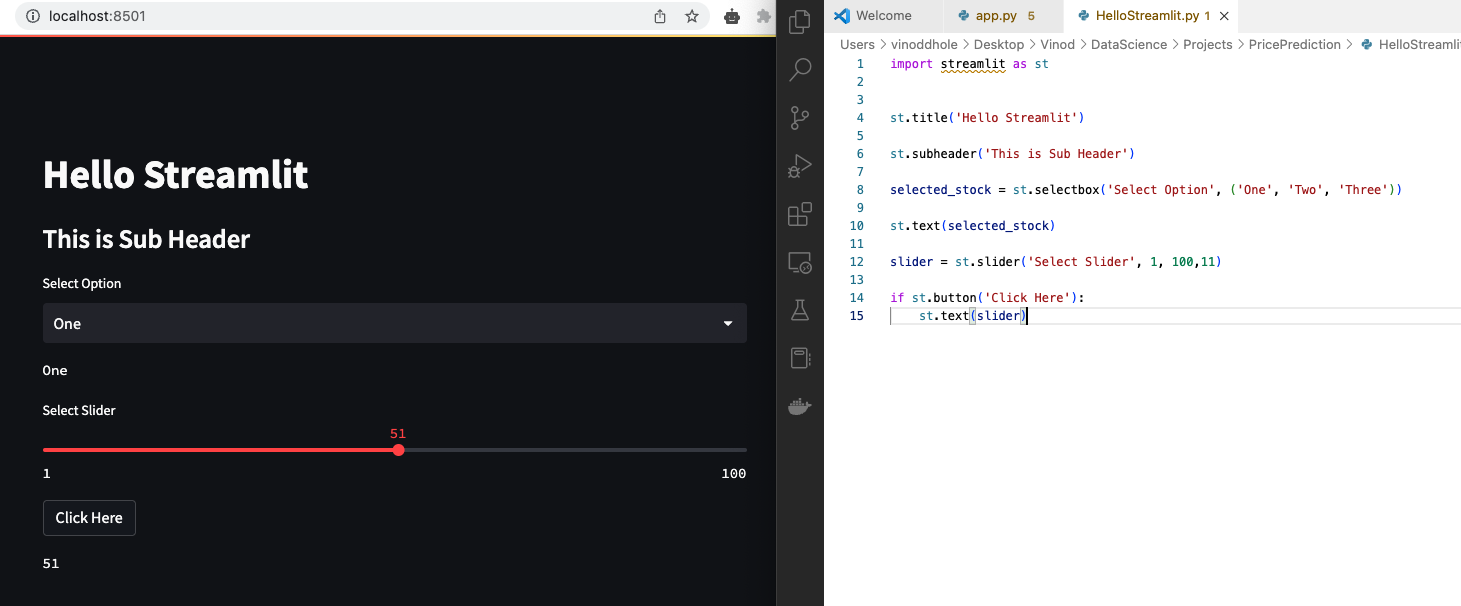<br>
    
* **displaying Data**<br>
     Add following code in the HelloStreamlit.py and save the file.<br> 
    `import pandas as pd`<br>
    `df = pd.DataFrame({'col_one':[1,2,3,4],'col_two':[11,22,33,44]})`<br>
    `st.subheader('Different ways of displaying Data')`<br>
    `st.dataframe(df)`<br>
    `st.write(df)`<br>
    `st.table(df)`<br>
    Web page should the DataFrame.<br>
    
    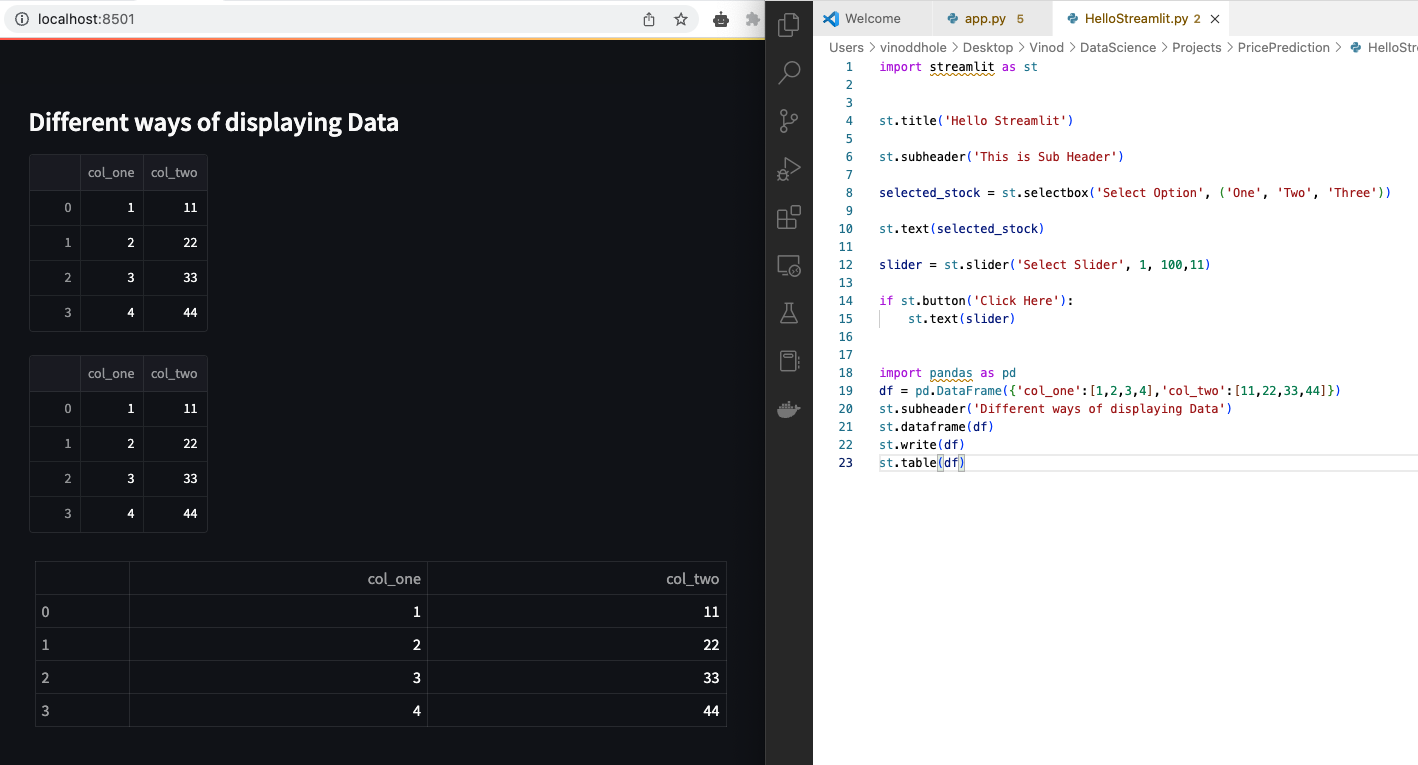<br><br>
    
This is enough information to create our web app. You can also refer [this](https://docs.streamlit.io/library/cheatsheet) very useful document.    

### Build the  Web App

All ground work is done lets get started with the web app. 

#### Managing credentials 
Run following code to create secret file, basically this code will grab the content of the **secrets.toml** file created earlier and create a new file under **.streamlit** directory.  

In [1]:
import toml
import os
directory = os.path.join(os.getcwd() + "/.streamlit")
if not os.path.exists(directory):
    os.makedirs(directory)
    
secrets = toml.load("secrets.toml")

output_file_name = os.path.join(directory+"/secrets.toml")
with open(output_file_name, "w") as toml_file:
    toml.dump(secrets, toml_file)

#### Create app.py


Create **app.py** file in the project directory, Copy paste following code in app.py and save the file.

Same file is uploaded [here](https://github.com/vinodvidhole/stockprice-predictions/blob/main/app.py)
  
The code might look overwhelming but Trust me, I simply combined all the code we have previously written in these three articles and incorporated it with the streamlit components we learned about earlier. Each line of code includes a helpful comment to aid in understanding. 
Feel free to customize you own changes in the code. 

This is just a basic App to demonstrate ML usage, You can improve look and feel of the app App as per your requirements. 


In [ ]:
#Import Required Libraries 
import streamlit as st
from snowflake.snowpark.session import Session
from plotly import graph_objs as go
import pandas as pd
import json
#import toml

#Extract credentials from secret file 
#secrets = toml.load("secrets.toml")
accountname = st.secrets["SNOWFLAKE"]["account"]
user = st.secrets["SNOWFLAKE"]["user"]
password = st.secrets["SNOWFLAKE"]["password"]
role = st.secrets["SNOWFLAKE"]["role"]
database = st.secrets["SNOWFLAKE"]["database"]
schema = st.secrets["SNOWFLAKE"]["schema"]
warehouse = st.secrets["SNOWFLAKE"]["warehouse"]

#Setting Menu options and web page configurations 
st.set_page_config(
     page_title="Stock Price Prediction",
     #layout="wide",
     page_icon="💹",
     initial_sidebar_state="expanded",
     menu_items={
         'Get Help': 'https://www.vinoddhole.com',
         'About': "The **Stock Price Prediction** App powered by AWS, Snowflake, Python, Snowpark and Streamlit"
     }
 )

# Create Session object
def create_session_object():
    connection_parameters = {
            "account": accountname,
            "user": user,
            "password": password,
            "role": role,
            "database": database,
            "schema": schema,
            "warehouse": warehouse,
            "ocsp_fail_open":"False"
        }

    session = Session.builder.configs(connection_parameters).create()

    print(session.sql('select current_warehouse(), current_database(), current_schema()').collect())
    return session

#Extract the data from SnowFlake load on pandas DataFrame 
def fetch_data(session):
    df = session.table('historical_prices').to_pandas()
    df.drop_duplicates(subset='DATE', keep="last",inplace=True)
    df = df.sort_values(by='DATE',ascending=False)
    return df
    
#Setting web page Title
st.title('Stock Price Prediction')

#Drop down selection for Ticker 
#Currently there is Only one option Google, can add more options like stocks = ('GOOG','AAPL')
stocks = ('GOOG',)
selected_stock = st.selectbox('Select Ticker', stocks)


if __name__ == "__main__":

    #Function call to connect to SnowFlake
    session = create_session_object()

    #Setting status progression text in webpage 
    data_load_state = st.text('Loading data...')
    
    #Function call to Get data 
    price_df = fetch_data(session)
    
    #Setting process completion text in webpage 
    data_load_state.text('Loading data... done!')

    st.subheader('Historical Prices')
    
    #Displaying Historical pricing data 
    st.dataframe(price_df)
       
    st.subheader('Historical Price Trend')

    #Creating Visualization for Historical Prices (This is exactly same code from Article 2)
    trace = go.Scatter(x=price_df['DATE'], y=price_df['CLOSE'],line_color='deepskyblue', name = 'Actual Prices')

    data = [trace]
    layout = dict(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                        label='1m',
                        step='month',
                        stepmode='backward'),
                    dict(count=3,
                        label='3m',
                        step='month',
                        stepmode='backward'),
                    dict(count=6,
                        label='6m',
                        step='month',
                        stepmode='backward'),
                    dict(count=12,
                        label='1Y',
                        step='month',
                        stepmode='backward'),
                    dict(count=5,
                        label='5Y',
                        step='year',
                        stepmode='backward'),
                    dict(step="all")
                ])
            ),
            title='Date',
            rangeslider=dict(
                visible = True
            ), type='date'
        ),
        yaxis=dict(title='Closing Price')
    )
    fig = dict(data=data, layout=layout)
    st.plotly_chart(fig)

    #Slider bar for users to select no. future days Range 1 - 1825 days, default is 180 days 
    days = st.slider('Select No. of days for prediction', 1, 1852,180)
    
    #Yes/No Selection option to show Historical Prices
    show_history = st.selectbox(
        "Show Historical Predicted Prices?",
        ("N", "Y")
    )

    #On Button click run code inside if statement 
    if st.button('Forecast Predictions'):
        
        prediction_state = st.text('Predicting Future Prices...')

        #Calling snowflake stored procedure "sproc_predict_using_prophet(table,show_hist, days", which will predict future prices (Same code grabbed from Article 3)
        pred_list = session.sql(
                "call sproc_predict_using_prophet('{}', '{}',{})".format('historical_prices',show_history, days)   
                ).collect()

        #Load the Prediction data from stored procedure into DataFrame 
        pred_df = pd.DataFrame(json.loads(pred_list[0][0]))
        pred_df = pred_df[['ds','yhat']]
        pred_df['ds'] = pd.to_datetime(pred_df['ds']).dt.date
        pred_df.columns = ['DATE', 'CLOSE']
        pred_df.sort_values(by='DATE',inplace=True)
        
        st.subheader('Predicted Prices')

        #Display the prediction output 
        st.dataframe(pred_df)
        st.subheader('Predicted Price Trend')

        trace0 = go.Scatter(x=price_df['DATE'], y=price_df['CLOSE'],line_color='deepskyblue', name='Actual Prices')

        trace1 = go.Scatter(x=pred_df['DATE'], y=pred_df['CLOSE'],line_color='lime', name='Predicted Prices')

        #Visualization of Actual Prices vs Predicted Prices (This is exactly same code from Article 2)
        data = [trace0, trace1]
        layout = dict(
            title='Actual Prices vs Predicted Prices',
            xaxis=dict(
                rangeselector=dict(
                    buttons=list([
                        dict(count=1,
                            label='1m',
                            step='month',
                            stepmode='backward'),
                        dict(count=3,
                            label='3m',
                            step='month',
                            stepmode='backward'),
                        dict(count=6,
                            label='6m',
                            step='month',
                            stepmode='backward'),
                        dict(count=12,
                            label='1Y',
                            step='month',                     
                            stepmode='backward'),
                        dict(count=5,
                            label='5Y',
                            step='year',
                            stepmode='backward'),
                        dict(step="all")
                    ])
                ),
                title='Date',
                rangeslider=dict(
                    visible = True
                ), type='date'
            ),
            yaxis=dict(title='Closing Price')
        )
        fig = dict(data=data, layout=layout)
        st.plotly_chart(fig)
        prediction_state.text('Prediction Done!')

#### Run Stock Price Prediction web app locally 

Time to run Stock Price Prediction web app. 

* **Open Terminal**<br>
    * Open Anaconda / Miniconda Terminal (as shown in earlier article)
    Type following commands<br>
    `conda deactivate`<br>
    `conda activate stocksenv`<br>

    * Navigate to Project directory using cd command<br>
    * Type following command to Add secret file to gitignore, This is one time deal to avoid accidentally upload of secret files  
    `echo ".streamlit/" >> .gitignore`<br>
    `echo "secrets.toml" >> .gitignore`<br>
    
    
* **Run Streamlit**<br> 
    Type following command on Terminal<br>
    `streamlit run app.py`<br>
    
    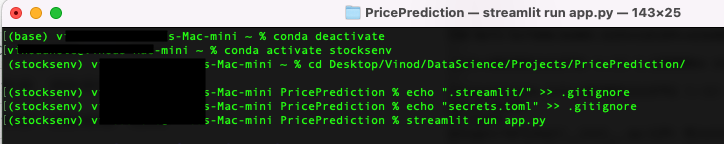<br>
    
    Running this command will open **Stock Price Prediction** web app on a browser<br> 

    Congratulations!!! The **Stock Price Prediction** web app has been created successfully. You can now check out the historical data and its Trend. Also you choose the number of days and show historical Prices option and upon clicking **Forecast Predictions**, you will be able to see the future prices and visualizations.
    
    ![](https://i.imgur.com/FyQW1Fo.gif)

### Deploy the Web App 

Our project journey has come to the end Phase. The web application is now complete and we need to host it on the internet so that anyone can access it online.

There are different method to Host the wen app but for our design the easies and best choice would be hosting it on Streamlit Community Cloud

We will Perform following steps.

* Upload the code on Github repository
* Deploy Web App on Streamlit Cloud

### Upload the code on Github repository

Log-In to the Github account, If you don't have the github account create a free account using [this](https://github.com/join) link.

#### Create a Github repository

* On top right side on the git hub page there is **+** sign , Click it and select **New Repository**
* Provide appropriate name like **stockprice-predictions**
* Select visibility as **Public** 
* Select **Add a README file**
* Add .gitignore , Select template as Python
* Choose Appropriate and Click **Create repository**

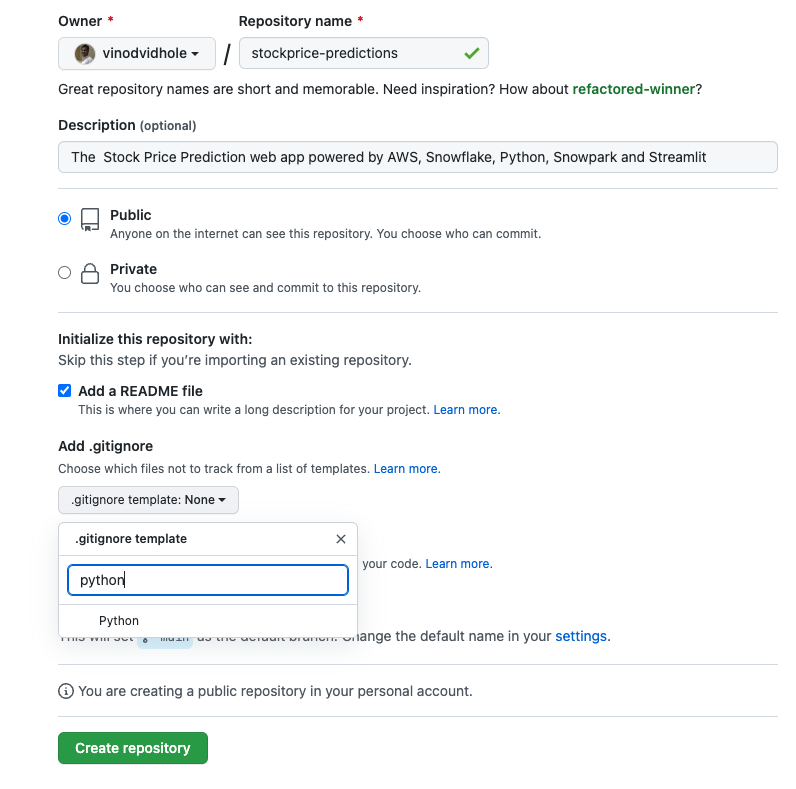

#### Upload the code 

* Go to github repository **stockprice-predictions**
* Click **Add file** and then select **Upload files**
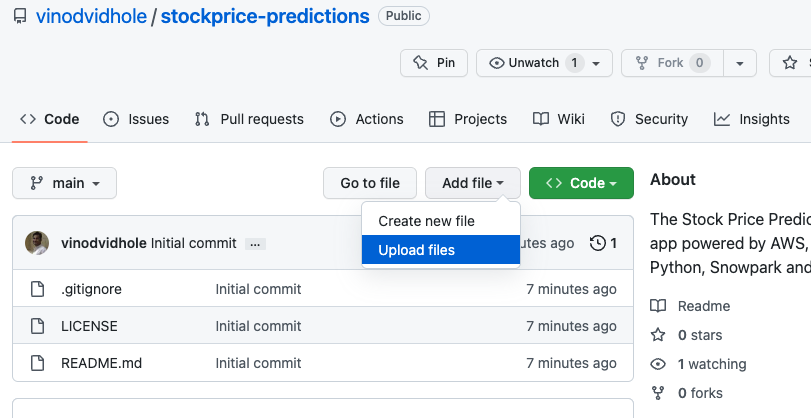

* Select option to upload the file, Navigate to Project Directory and select **app.py**
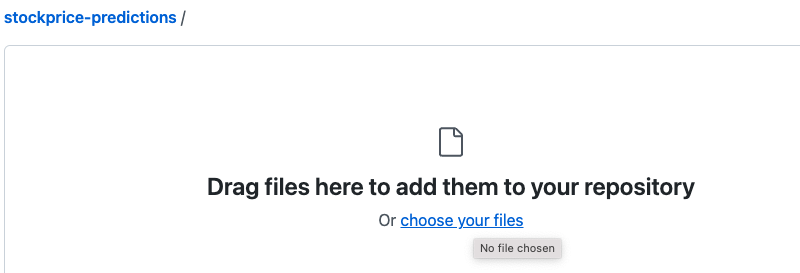

* Download the **requirements.txt** file from [here](https://github.com/vinodvidhole/stockprice-predictions/blob/main/requirements.txt) and upload this file to github repository **stockprice-predictions**
* Click on **Commit Changes** button.
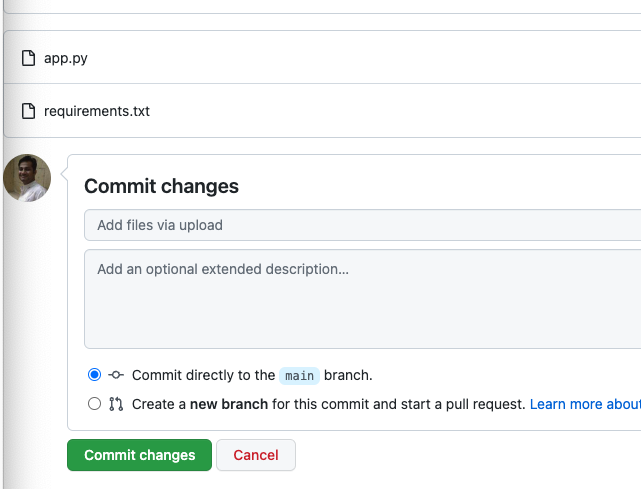

* app.py & requirements.txt should be available in github repository.
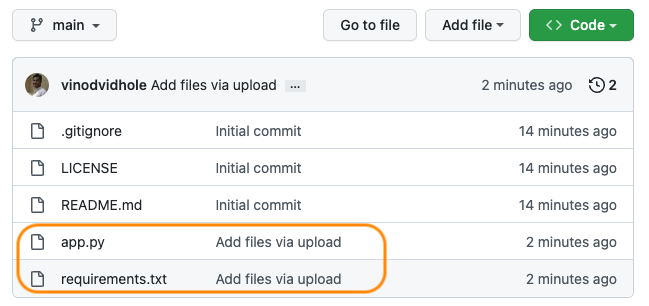

### Deploy Web App on Streamlit Cloud

Log-In to the Streamlit Cloud account, If you don't have the Streamlit Cloud account create one for free using [this](https://share.streamlit.io/signup) link.

#### Link Github Account to Streamlit Cloud
* On Streamlit Cloud account click on **Settings** located at top right 
* Go to **LInked accounts** , Then Click **Sign in with  GitHub**

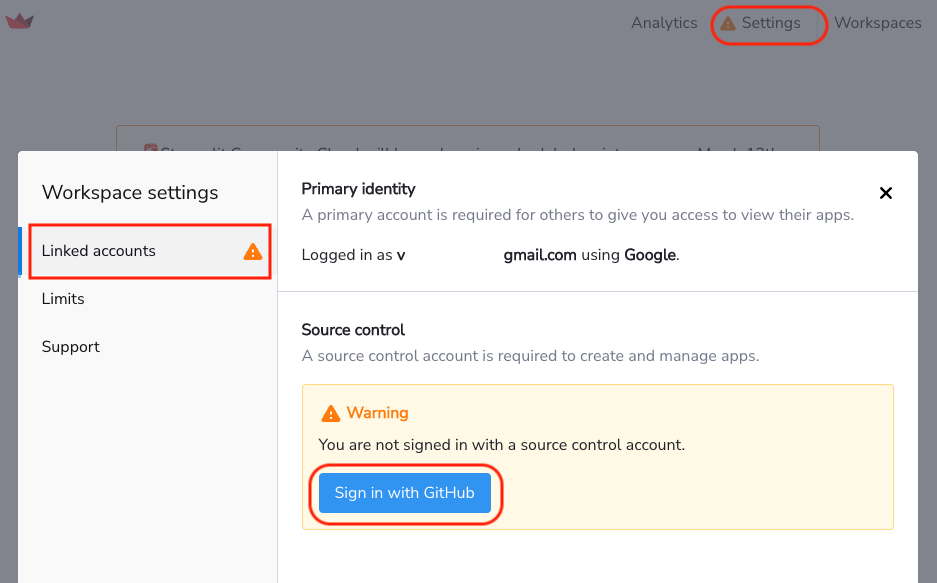

* Provide the GitHub credentials and link the account 

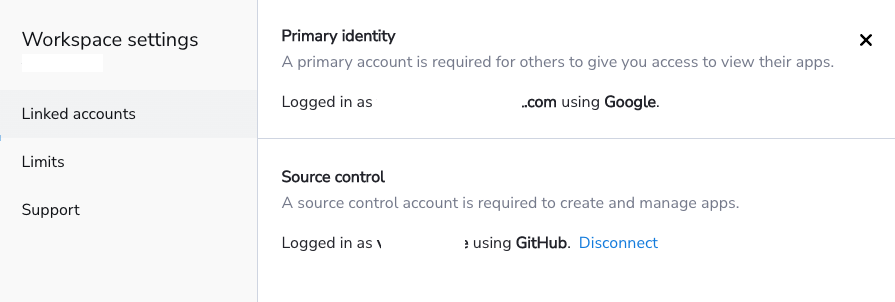

#### Create App on Streamlit Cloud

* Go back to Home page, Click on **New app**, this will open **Deploy an app** page 

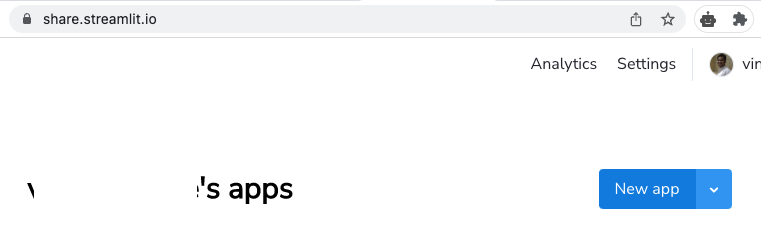



* Select **stockprice-predictions** repository 
* Select **main** Branch
* Select **app.py** in Main file path
* Click on **Advanced settings...**, this will open a new pop-up window

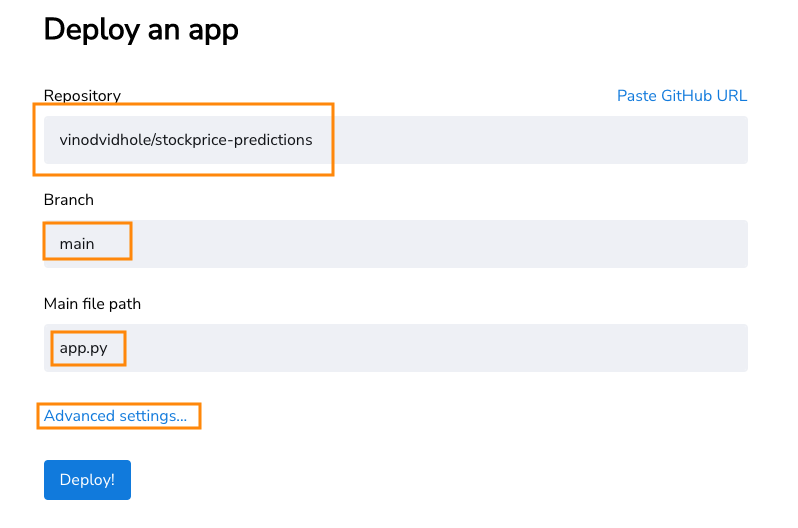



* Select Python version as **3.8**
* Copy the contents of **secrets.toml** file (this file was created earlier) and paste it in the Secrets section and click **Save** 

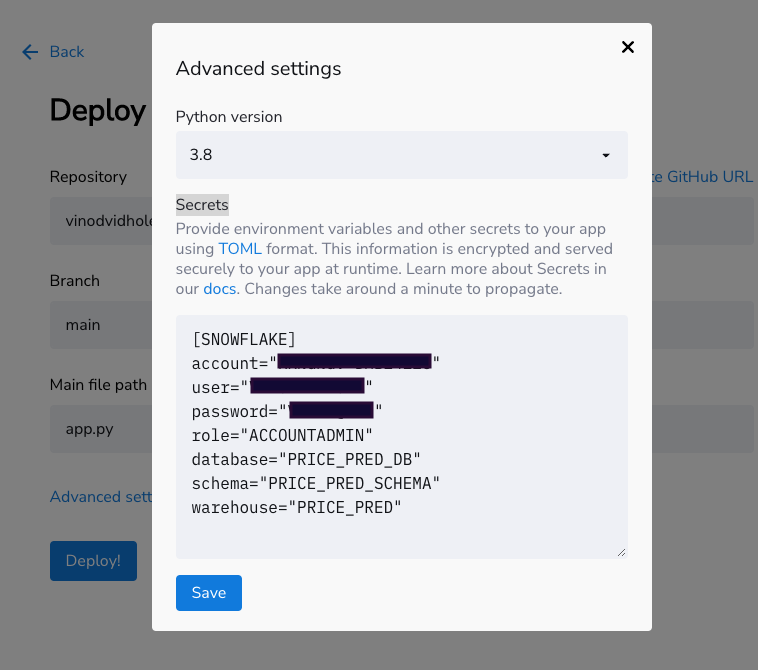

* Finally click on **Deploy** button, this will start the deployment process. 

Deployment should take few minutes, depending on Internet  speed and available resources, If everything went well then **Stock Price Prediction** App should deploy successfully.  

Use following URL to access the live web App<br>

### **Application URL :** https://stockprice-predictions.streamlit.app/ ###

#### Web App Maintenance

Application maintenance is very easy

* On home page you can select **there dots** , this will give multiple options to Check Analytics, Rebooting App, Changing setting etc.

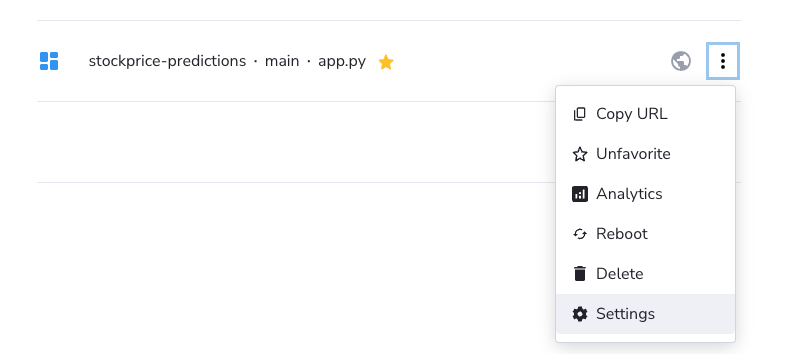

* In the **Settings** you have option to change url, maintain the permissions of the App & modify the credentials.
* On the Application right bottom there is option of **Manage app**, here you can check or download the logs. This is useful while debugging.

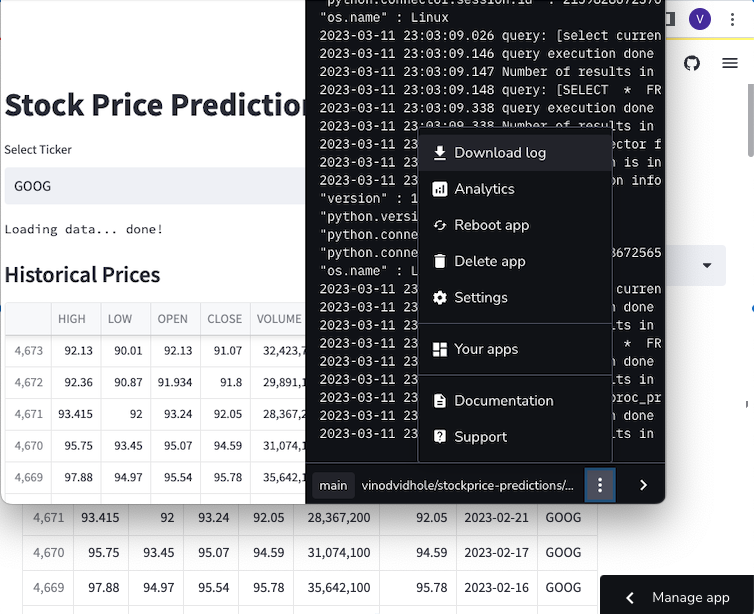

#### CI/CD (Continuous Integration/Continuous Deployment)

Making the code changes to App and Redeployment is very. Actually its Automated. You just have to check in the additional changes to GitHub. and App redeployment will be kick-started immediately.

Now Lets do some modification to app, I want to add a side in the he web app to display some information about the app.

I added following code below page configurations section in app.py

`st.sidebar.title("Stock Price Prediction")`<br>
`st.sidebar.markdown("The **Stock Price Prediction** App powered by AWS, Snowflake, Python, Snowpark and Streamlit")`<br>
`st.sidebar.markdown("Author: [Vinod Dhole](https://www.vinoddhole.com)")`<br>
`st.sidebar.markdown("Source: [Github](https://github.com/vinodvidhole/stockprice-predictions)")`<br>

I applied the changes to the GitHub code and checked-in the changes, That's all it takes. The updated code should automatically redeployed to the cloud. It's incredibly effortless.

You can open the [app](https://stockprice-predictions.streamlit.app/) and the changes should be available.

#### Verify the App

At last, the project is completed and the web application is now live on the Internet. Let's open it on a mobile device and verify.

![](https://i.imgur.com/TYqCrkj.gif)

Hurray...I was able to run this App on my mobile device, you can also give it a [try](https://stockprice-predictions.streamlit.app/). Please note that since we deployed this App using free resources, there might be slight delay in predictions on some devices.

## References
References to some useful links.

* https://docs.snowflake.com/developer-guide/snowpark/python/creating-sprocs
* https://docs.snowflake.com/developer-guide/snowpark/python/calling-functions
* https://docs.snowflake.com/developer-guide/snowpark/python/python-snowpark-training-ml
* https://interworks.com/blog/2022/09/20/a-definitive-guide-to-creating-python-stored-procedures-in-snowflake-using-snowpark/
* https://github.com/join
* https://github.com/vinodvidhole/stockprice-predictions/blob/main/app.py
* https://github.com/vinodvidhole/stockprice-predictions/blob/main/requirements.txt
* https://share.streamlit.io/signup
* https://docs.streamlit.io/library/cheatsheet
* https://stockprice-predictions.streamlit.app/
* https://github.com/vinodvidhole/stockprice-predictions
* https://medium.com/@vinodvidhole

## Future Work
Here are some ideas for future work

* You can enhance this project to support more Tickers Like APPLE, MSFT etc.
* You can implement LSTM (long short-term memory) neural networks to predict stock prices.
* You can create a Treading bot, using this Machine Learning Models
* You can perform the sentiment Analysis of News, Social Media to Enhance the Predictions.

## Conclusion 

As usual, here are the links to the whole guide, in case you need to refer to a past article. 

Part 1: Data Collection And Data Storage  TODO link

Part 2: Data Extraction, Preprocessing, EDA And Machine Learning Model development  TODO link 

Part 3: Machine Learning Model deployment And Web App development (This article) TODO Link 


Hope I was able to teach you entire life cycle of the Machine Learning Project, and now you can use this knowledge in your future projects.

If you have any questions or any feedback feel free to post a comment or contact me on [LinkedIn](https://www.linkedin.com/in/vinodvidhole/). Thank you for reading and Until next time… Happy coding !!